In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils import resample
import shap

c:\My Folder\projects\canbrs-therapeutics\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./datasets/canbrs_dataset_polish.csv")
df.head()

,ID,age,year_of_diagnosis,race,marital_status,primary_site,regional_nodes_positive,regional_nodes_examined,site_bone,site_brain,site_liver,site_lung,subtype,er_status,pr_status,her2_status,Outcome
0,A1,77,2010,w1,m1,509,98,0,Unknown,Unknown,Unknown,Unknown,3,Positive,Negative,Negative,Dead
1,A2,82,2010,w1,w5,501,98,0,Yes,No,No,No,3,Positive,Negative,Negative,Dead
2,A3,42,2011,w1,s3,509,98,0,Yes,No,Yes,Yes,1,Negative,Negative,Negative,Dead
3,A4,72,2012,w1,w5,509,98,0,No,No,No,Yes,1,Negative,Negative,Negative,Dead
4,A5,85,2013,w1,w5,508,98,0,Yes,No,No,No,4,Positive,Positive,Positive,Dead


In [3]:
data = df.copy()

In [4]:
def bin_status(status):
    if pd.isnull(status) or status == 'Unknown':
        return np.nan
    elif status == 'Negative':
        return 0
    elif status == 'Positive':
        return 1
    else:
        return np.nan

data['ER_bin'] = data['er_status'].apply(bin_status)
data['PR_bin'] = data['pr_status'].apply(bin_status)

data = data.drop(['er_status', 'pr_status'], axis=1)

## N-status derived (# positive nodes)

In [5]:
def map_n_status(row):
    count_positive = sum(row[col] == 'Yes' for col in ['site_bone', 'site_brain', 'site_liver', 'site_lung'])
    if count_positive == 0:
        return '0'
    elif 1 <= count_positive <= 3:
        return '1-3'
    else:
        return '4+'

In [6]:
le_outcome = LabelEncoder()
data['Outcome'] = le_outcome.fit_transform(data['Outcome'])

label_encoders = {}

label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

data = data.round().astype(int)

# N Status Added here.

data['N_status'] = data.apply(map_n_status, axis=1)
data['N_status_encoded'] = data['N_status'].map({'0': 0, '1-3': 1, '4+': 2})

if 'ID' in data.columns:
    data = data.drop('ID', axis=1)
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [8]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=42)

In [9]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))


Cross-Validation Accuracy Scores: [0.84798995 0.94339623 0.94716981 0.9408805  0.93584906]
Mean Cross-Validation Accuracy: 0.923057109446604


In [10]:
X_train.head()

,age,year_of_diagnosis,race,marital_status,primary_site,regional_nodes_positive,regional_nodes_examined,site_bone,site_brain,site_liver,site_lung,subtype,her2_status,ER_bin,PR_bin,N_status,N_status_encoded
0,52,2019,4,4,509,98,0,2,0,2,0,3,0,1,1,0.0,0
1,77,2013,4,0,505,98,0,2,0,0,0,3,0,1,1,0.0,0
2,52,2014,4,4,502,98,0,2,0,2,0,4,1,1,1,0.0,0
3,85,2011,4,2,508,5,5,0,0,2,0,1,0,0,0,0.0,0
4,67,2021,4,0,509,98,0,0,0,2,0,1,0,0,0,0.0,0


In [12]:
X_shap = X_train.copy()
X_shap = X_shap.drop("year_of_diagnosis", axis=1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# if isinstance(shap_values, list):
#     class_idx = 1 if len(shap_values) > 1 else 0
#     shap.summary_plot(shap_values[class_idx], X_shap, plot_type="bar", max_display=20)
# else:
#     shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=20)

print(shap_values)

[[[ 3.70750857e-02 -3.70750857e-02]
  [-3.03582027e-01  3.03582027e-01]
  [-2.42574253e-02  2.42574253e-02]
  ...
  [ 2.94152608e-03 -2.94152608e-03]
  [ 1.16155049e-03 -1.16155049e-03]
  [ 0.00000000e+00  0.00000000e+00]]

 [[-5.89598268e-02  5.89598268e-02]
  [-3.06850563e-01  3.06850563e-01]
  [ 2.76518292e-02 -2.76518292e-02]
  ...
  [-1.74877731e-03  1.74877731e-03]
  [-4.60758083e-05  4.60758083e-05]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 3.70750857e-02 -3.70750857e-02]
  [-3.03582027e-01  3.03582027e-01]
  [-2.42574253e-02  2.42574253e-02]
  ...
  [ 2.94152608e-03 -2.94152608e-03]
  [ 1.16155049e-03 -1.16155049e-03]
  [ 0.00000000e+00  0.00000000e+00]]

 ...

 [[-6.22568845e-02  6.22568845e-02]
  [-3.33025722e-01  3.33025722e-01]
  [-1.66097652e-02  1.66097652e-02]
  ...
  [-4.12032964e-03  4.12032964e-03]
  [-3.57712672e-04  3.57712672e-04]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 1.25629724e-02 -1.25629724e-02]
  [-2.87070835e-01  2.87070835e-01]
  [ 3.88815436e-02 -3.8881

Generating SHAP beeswarm plot (directionality) for Class 1 — top 10 features


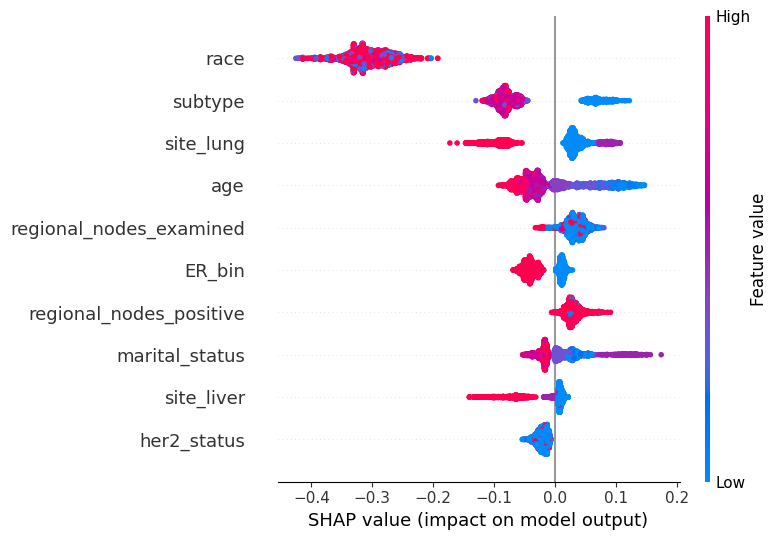

In [13]:
print("Generating SHAP beeswarm plot (directionality) for Class 1 — top 10 features")

shap.summary_plot(
    shap_values[:, :, 0],
    X_shap,
    plot_type="dot",
    max_display=10,
    show=True
)

## Understanding Shap Plots

- Each dot represents a SHAP value for a single prediction and a single feature.
- X-axis shows the SHAP value — the impact a feature has on the prediction.
  - Positive SHAP values push the model prediction towards class 0 (in this case).
  - Negative SHAP values push the model prediction away from class 0 (towards class 1).
- Color indicates the original value of the feature:
  - Red = high feature value
  - Blue = low feature value
- Y-axis shows the feature names, ranked by importance (mean absolute SHAP value).

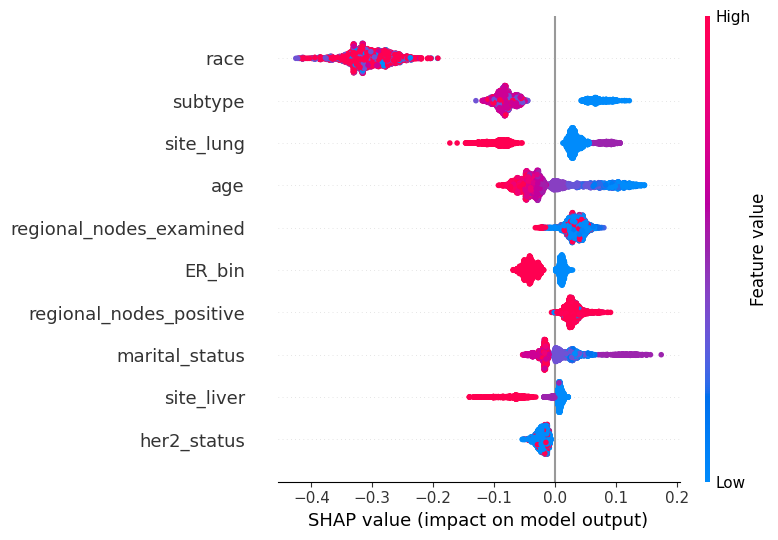

In [14]:
import shap

# For class 0:
shap.summary_plot(shap_values[:, :, 0], X_shap, plot_type="dot", max_display=10)

In [15]:
import pandas as pd
import numpy as np

class_idx = 0

shap_class_values = shap_values[:, :, class_idx]

mean_abs_shap = np.abs(shap_class_values).mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': X_shap.columns,
    'Mean_ABS_SHAP': mean_abs_shap
}).sort_values(by='Mean_ABS_SHAP', ascending=False)

print(shap_df.head(10))

                    Feature  Mean_ABS_SHAP
1                      race       0.303812
10                  subtype       0.079546
9                 site_lung       0.053677
0                       age       0.047736
5   regional_nodes_examined       0.034571
12                   ER_bin       0.031542
4   regional_nodes_positive       0.029839
2            marital_status       0.026544
8                site_liver       0.025904
11              her2_status       0.021045


## Understanding Plots for Class 0 (same goes for Class 1 as well)

- Feature Importance Ranking:
  - var2 is the most influential feature for predicting class 0.
  - It’s followed by v10, v11, V1, etc., consistent with your Mean_ABS_SHAP table.
- Direction of Influence:
  - For var2, high values (red) consistently result in positive SHAP values, which push predictions toward class 0.
  - For v10, low values (blue) lead to positive SHAP values, while high values (red) push the prediction away from class 0.
- Feature Behavior:
  - V1: Appears to have a nonlinear impact — both high and low values are spread across the SHAP axis, meaning it can push predictions in either direction depending on context.
  - v7: Low values (blue) mostly push toward class 1 (negative SHAP), while high values push slightly toward class 0.


## Some more insights

- var2 strongly contributes to the model predicting class 0 when it’s high.
- v10, when low, also supports class 0, while high values oppose it — making it a risk indicator for class 1.
- Features like v6 and V5 also have directional impact — they can both positively or negatively affect the prediction depending on the value.

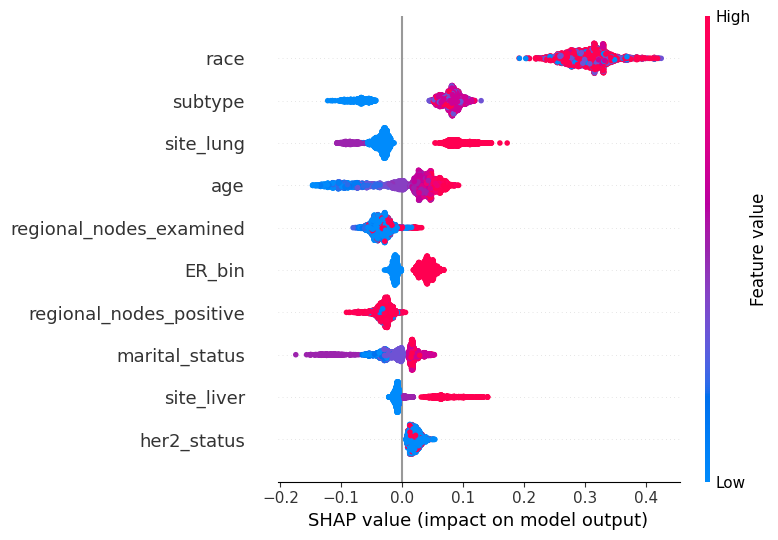

In [16]:
# For class 1:
shap.summary_plot(shap_values[:, :, 1], X_shap, plot_type="dot", max_display=10)

In [17]:
import pandas as pd
import numpy as np

class_idx = 1

shap_class_values = shap_values[:, :, class_idx]

mean_abs_shap = np.abs(shap_class_values).mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': X_shap.columns,
    'Mean_ABS_SHAP': mean_abs_shap
}).sort_values(by='Mean_ABS_SHAP', ascending=False)

print(shap_df.head(10))

                    Feature  Mean_ABS_SHAP
1                      race       0.303812
10                  subtype       0.079546
9                 site_lung       0.053677
0                       age       0.047736
5   regional_nodes_examined       0.034571
12                   ER_bin       0.031542
4   regional_nodes_positive       0.029839
2            marital_status       0.026544
8                site_liver       0.025904
11              her2_status       0.021045


Accuracy: 0.9116666666666666

Classification Report:
               precision    recall  f1-score   support

       Alive       0.74      0.78      0.76       108
        Dead       0.95      0.94      0.95       492

    accuracy                           0.91       600
   macro avg       0.85      0.86      0.85       600
weighted avg       0.91      0.91      0.91       600



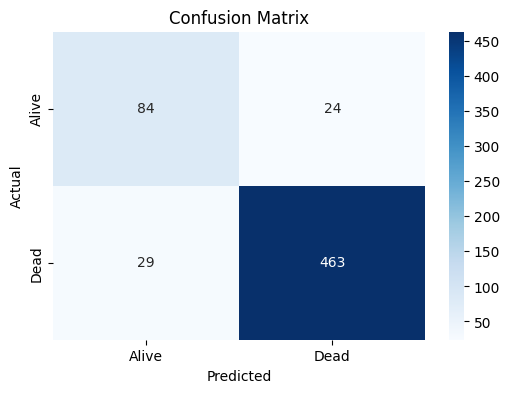

ROC AUC Score: 0.9435881511592894


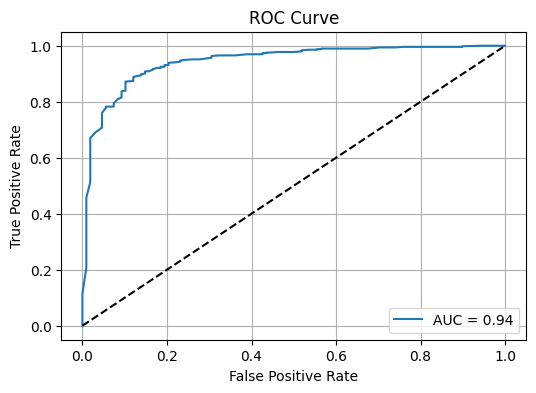

In [18]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_outcome.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_outcome.classes_, yticklabels=le_outcome.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

if y_pred_proba is not None:
    auc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    print("ROC AUC Score:", auc_score)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    print("ROC AUC Score and Curve not available (model does not support probability estimates).")

Brier Score: 0.07050523733450187


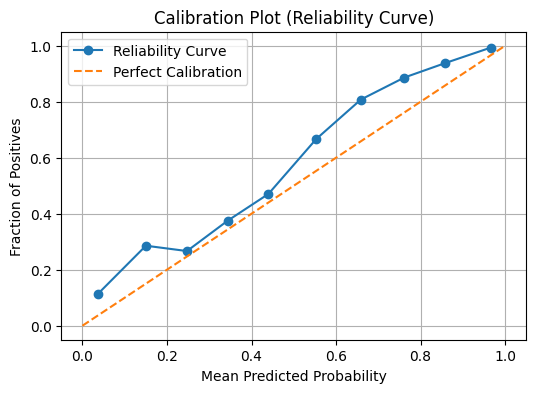

PR AUC Score: 0.9846731623326093


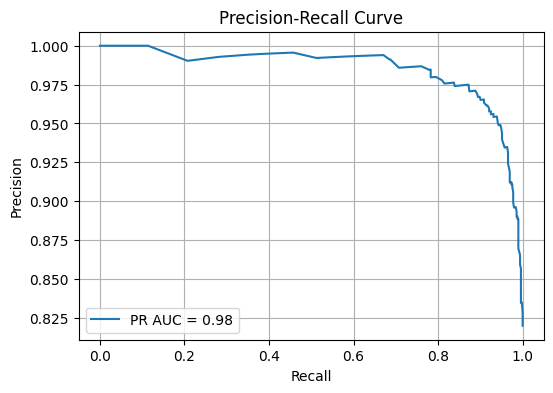

ROC AUC 95% CI: (0.917, 0.965)
PR AUC 95% CI: (0.974, 0.992)


In [19]:
if y_pred_proba is not None:
    brier_score = brier_score_loss(y_test, y_pred_proba)
    print("Brier Score:", brier_score)

    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    plt.figure(figsize=(6,4))
    plt.plot(prob_pred, prob_true, marker='o', label='Reliability Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot (Reliability Curve)')
    plt.legend()
    plt.grid()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    print("PR AUC Score:", pr_auc)

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    n_bootstraps = 1000
    rng = np.random.RandomState(42)
    roc_auc_scores = []
    pr_auc_scores = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_test), len(y_test))
        if len(np.unique(y_test.iloc[indices])) < 2:
            continue
        score_roc = roc_auc_score(y_test.iloc[indices], y_pred_proba[indices])
        score_pr = average_precision_score(y_test.iloc[indices], y_pred_proba[indices])
        roc_auc_scores.append(score_roc)
        pr_auc_scores.append(score_pr)

    roc_ci_lower = np.percentile(roc_auc_scores, 2.5)
    roc_ci_upper = np.percentile(roc_auc_scores, 97.5)
    pr_ci_lower = np.percentile(pr_auc_scores, 2.5)
    pr_ci_upper = np.percentile(pr_auc_scores, 97.5)

    print(f"ROC AUC 95% CI: ({roc_ci_lower:.3f}, {roc_ci_upper:.3f})")
    print(f"PR AUC 95% CI: ({pr_ci_lower:.3f}, {pr_ci_upper:.3f})")


In [20]:
print(le_outcome.classes_)

['Alive' 'Dead']
